# Imports

In [4]:
#Import Section
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from env import user, password, host
from os.path import exists

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn import preprocessing

import warnings
warnings.filterwarnings("ignore")


# Acquire

In [10]:
#function to acquire zillow data from codeup database --> place in wrangle.py module
def acquire_zillow():
    #create url to access DB
    url = f"mysql+pymysql://{user}:{password}@{host}/zillow"

    #sql to acquire data. 
    sql = """
    SELECT bedroomcnt as bedrooms, 
        bathroomcnt as bathrooms, 
        calculatedfinishedsquarefeet as area, 
        taxvaluedollarcnt as home_value,
        yearbuilt as year_built, 
        taxamount as tax_amount, 
        fips as county
    FROM properties_2017
    LEFT JOIN propertylandusetype USING (propertylandusetypeid)
    LEFT JOIN predictions_2017 USING (parcelid)
    WHERE propertylandusedesc IN ("Single Family Residential", "Inferred Single Family Residential") 
        AND transactiondate like '%%2017%%'
    """

    #read the data in a dataFrame. will use pre-existing csv file if available;
    if exists('zillow_data.csv'):
        df = pd.read_csv('zillow_data.csv').drop(columns='Unnamed: 0')
    else:
        df = pd.read_sql(sql, url)

    #drops null values from df    
    df = df.dropna(axis=0)

    return df

In [11]:
#initial data acquisition
df = acquire_zillow()

In [12]:
df.head()

,bedrooms,bathrooms,area,home_value,year_built,tax_amount,county
0,4.0,3.5,3100.0,1023282.0,1998.0,11013.72,6059.0
1,2.0,1.0,1465.0,464000.0,1967.0,5672.48,6111.0
2,3.0,2.0,1243.0,564778.0,1962.0,6488.30,6059.0
3,4.0,3.0,2376.0,145143.0,1970.0,1777.51,6037.0
4,4.0,3.0,2962.0,773303.0,1950.0,9516.26,6037.0


In [17]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52441 entries, 0 to 52440
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   bedrooms    52441 non-null  float64
 1   bathrooms   52441 non-null  float64
 2   area        52359 non-null  float64
 3   home_value  52440 non-null  float64
 4   year_built  52325 non-null  float64
 5   tax_amount  52437 non-null  float64
 6   county      52441 non-null  float64
dtypes: float64(7)
memory usage: 2.8 MB


In [18]:
df.isnull().sum()

bedrooms        0
bathrooms       0
area           82
home_value      1
year_built    116
tax_amount      4
county          0
dtype: int64

In [20]:
#drops null values --> total goes from 52441 to 52315 --> added to acquire_zillow function
df = df.dropna(axis=0)


## Takeways
* small amount of nulls in area, home_value, year_built, and tax_amount
    - drop them. less than 1% of data
    - add code to drop nulls into the initial acquisition function

# Prepare

In [22]:
round(df.describe(),2)

,bedrooms,bathrooms,area,home_value,year_built,tax_amount,county
count,52315.00,52315.00,52315.00,52315.00,52315.00,52315.00,52315.00
mean,3.31,2.30,1922.55,528044.82,1963.40,6434.75,6049.09
std,0.94,1.02,1003.63,748457.59,23.13,8709.64,20.99
min,0.00,0.00,128.00,1000.00,1878.00,49.18,6037.00
25%,3.00,2.00,1268.00,193701.00,1950.00,2656.18,6037.00
50%,3.00,2.00,1658.00,373374.00,1961.00,4645.42,6037.00
75%,4.00,3.00,2305.00,618617.00,1979.00,7371.64,6059.00
max,14.00,18.00,21929.00,49061236.00,2016.00,586639.30,6111.00


## Takeaways
* change county fips code to actual county names --> 
* can area be used to create small, med, large features --> save for post mvp pass
* change types for county, year_built --> categorical

In [ ]:
def prep(df):
    """
    Purpose
        To return dataset for exploration

    Parameters
        df: dataframe to perform desired operations on

    Returns
        train, validate, and test datasets
    """

    #change county fips codes to county names
    df.county = df.county.map({6037: 'LA County', 6059: 'Orange County', 6111: 'Ventura County'})

    #remove outliers
    df = remove_outliers(df, 1.5, ['bedrooms', 'bathrooms', 'area', 'home_value', 'tax_amount'])

    #change datatypes of categorical columns
    df.county = df.county.astype('object')
    df.year_built = df.year_built.astype('int').astype('object')

    #plot basic visuals of column counts, boxplots for numeric columns, and 
    plt.figure(figsize=(20,5))
    i=1

    for col in df.columns:
        plt.subplot(1, len(df.columns), i)
        df[col].hist(bins=5)
        plt.title(col)
        i += 1
    plt.tight_layout()
    plt.show()

    #boxplot visual
    plt.figure(figsize=(20,5))
    i=1

    for col in df.drop(columns=['county', 'year_built']).columns:
    
        plt.subplot(1, len(df.columns), i)
        sns.boxplot(data=df[col])
        plt.title(col)
        i += 1
    plt.tight_layout()
    plt.show()
    
    return df

In [23]:
#change county fips codes to county names
df.county = df.county.map({6037: 'LA County', 6059: 'Orange County', 6111: 'Ventura County'})

array(['6059.0', '6111.0', '6059.0', ..., '6111.0', 'LA County',
       'LA County'], dtype='<U32')

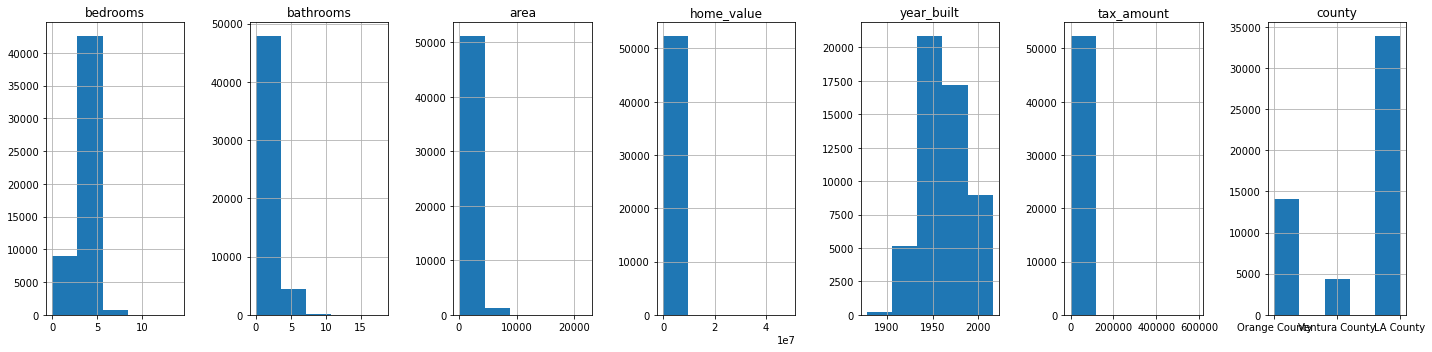

In [35]:
# check for outliers
plt.figure(figsize=(20,5))
i=1

for col in df.columns:
    plt.subplot(1, len(df.columns), i)
    df[col].hist(bins=5)
    plt.title(col)
    i += 1
plt.tight_layout()
plt.show()


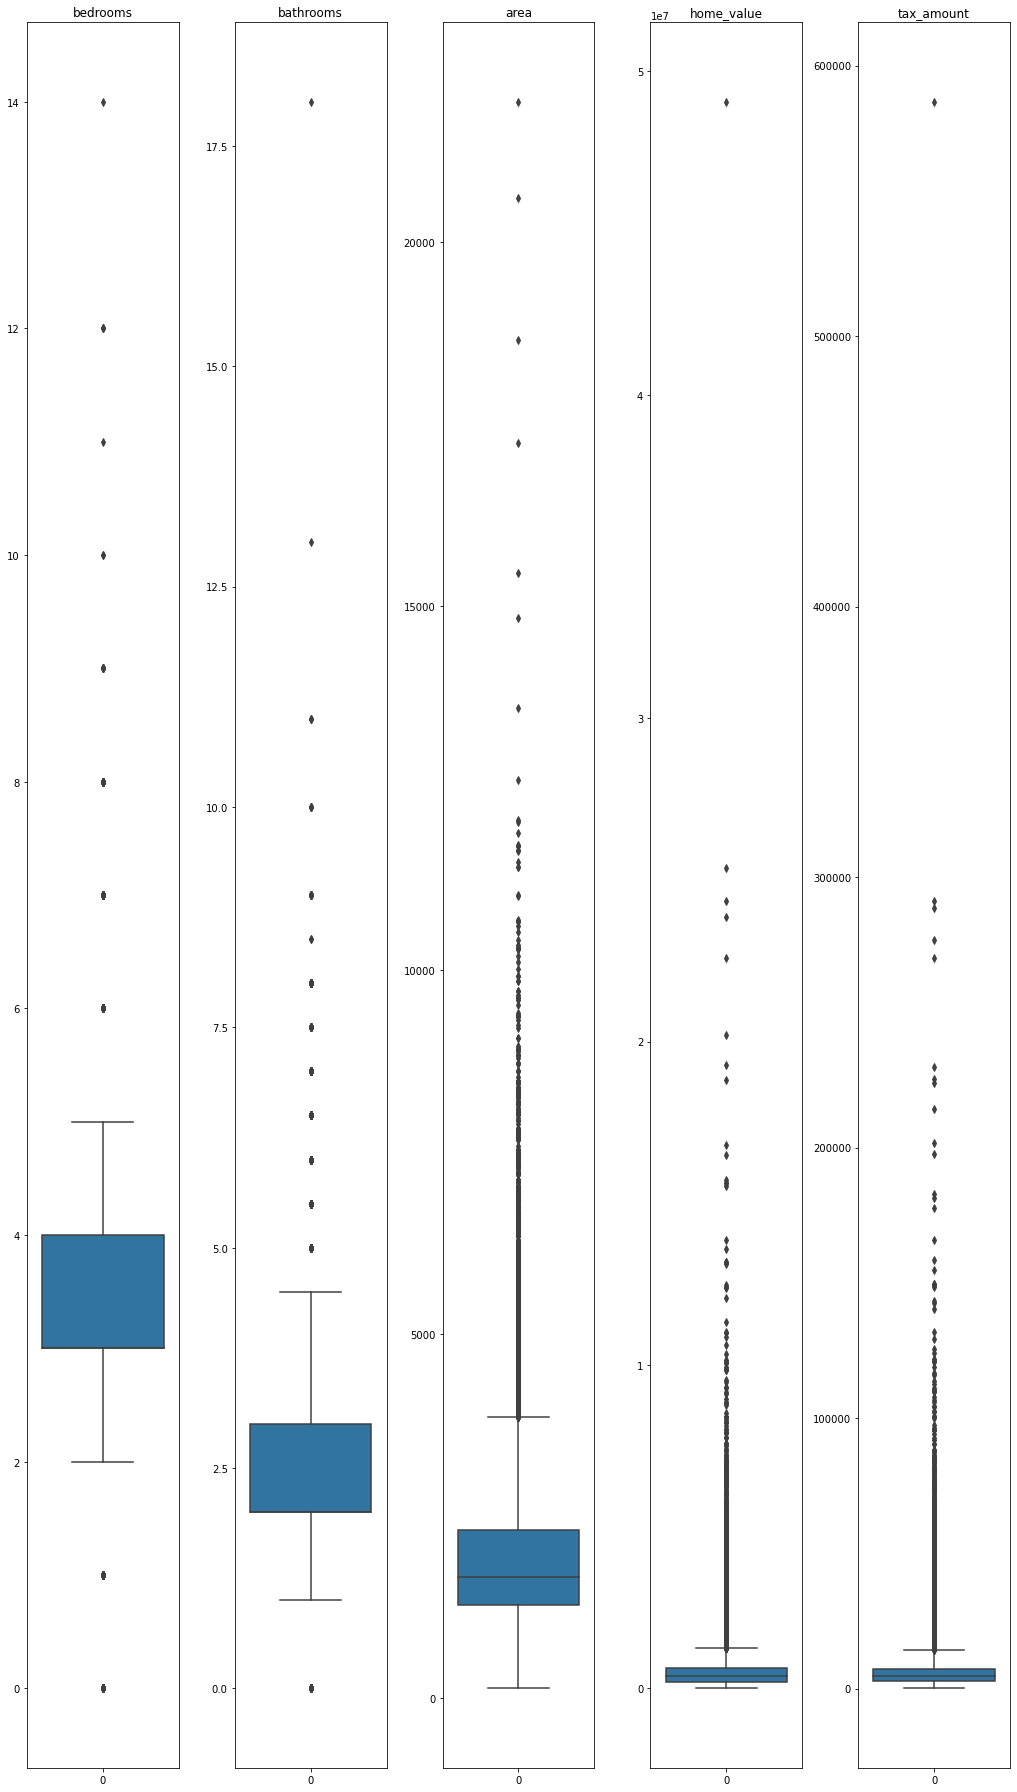

In [40]:
# use a loop now --> can not show fips or year built
plt.figure(figsize=(20,25))
i=1

for col in df.drop(columns=['county', 'year_built']).columns:
   
    plt.subplot(1, len(df.columns), i)
    sns.boxplot(data=df[col])
    plt.title(col)
    i += 1
plt.tight_layout()
plt.show()

## Takeaways
* Outliers --> bedrooms, bathrooms, area, homevalue, tax_amount
 - Create function to remove outliers --> add to wrangle.py, include function call within prep function


In [ ]:
# function for removing outliers
def remove_outliers(df, k, col_list):
    """ 
    remove outliers from a list of columns in a dataframe and return that dataframe
    """

    # total number of observations
    num_obs = df.shape[0]
        
    # Create a column that will label our rows as containing an outlier. sets default value
    df['outlier'] = False

    # loop through the columns provided to find appropriate values and labels
    for col in col_list:

        # find quartiles
        q1, q3 = df[col].quantile([.25, .75])  
        
       # get interquartile range
        iqr = q3 - q1

       # find upper/lower bounds 
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # update the outlier label as needed. 
        df['outlier'] = np.where(((df[col] < lower_bound) | (df[col] > upper_bound)) & (df.outlier == False), True, df.outlier)
    
    # set dataframe to dataframe w/o the outliers
    df = df[df.outlier == False]

    # drop the outlier column from the dataFrame. no longer needed
    df.drop(columns=['outlier'], inplace=True)

    # print out number of removed observations
    print(f"Number of observations removed: {num_obs - df.shape[0]}")
        
    return df

In [43]:
#use the above function --> 1.5*IQR is considered fairly restrictive 
df = remove_outliers(df, 1.5, ['bedrooms', 'bathrooms', 'area', 'home_value', 'tax_amount'])
df

Number of observations removed: 5898


,bedrooms,bathrooms,area,home_value,year_built,tax_amount,county
0,4.0,3.5,3100.0,1023282.0,1998.0,11013.72,Orange County
1,2.0,1.0,1465.0,464000.0,1967.0,5672.48,Ventura County
2,3.0,2.0,1243.0,564778.0,1962.0,6488.30,Orange County
3,4.0,3.0,2376.0,145143.0,1970.0,1777.51,LA County
4,4.0,3.0,2962.0,773303.0,1950.0,9516.26,LA County
...,...,...,...,...,...,...,...
52436,4.0,2.0,1633.0,346534.0,1962.0,4175.08,LA County
52437,2.0,2.0,1286.0,354621.0,1940.0,4478.43,LA County
52438,4.0,2.0,1612.0,67205.0,1964.0,1107.48,Ventura County
52439,3.0,1.0,1032.0,49546.0,1954.0,876.43,LA County


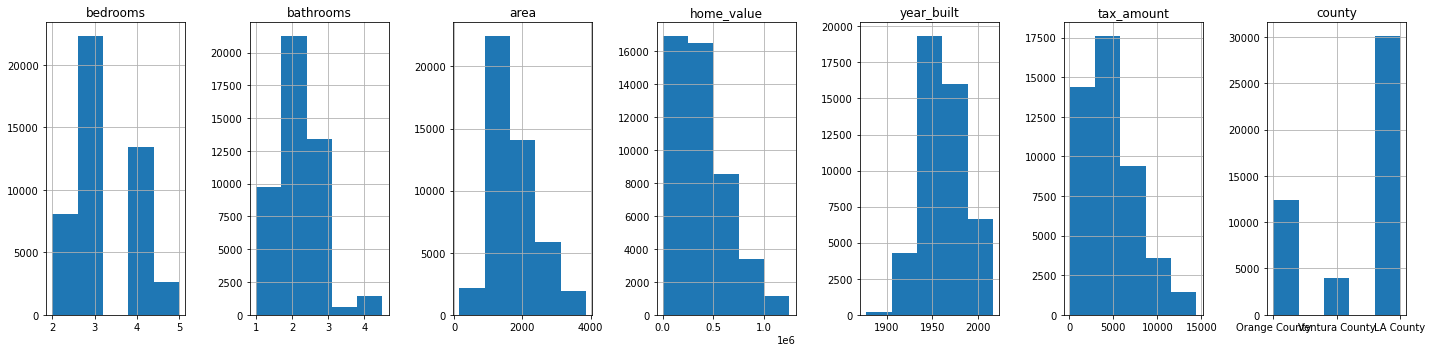

In [44]:
# visualize data with outliers removed
plt.figure(figsize=(20,5))
i=1

for col in df.columns:
    plt.subplot(1, len(df.columns), i)
    df[col].hist(bins=5)
    plt.title(col)
    i += 1
plt.tight_layout()
plt.show()

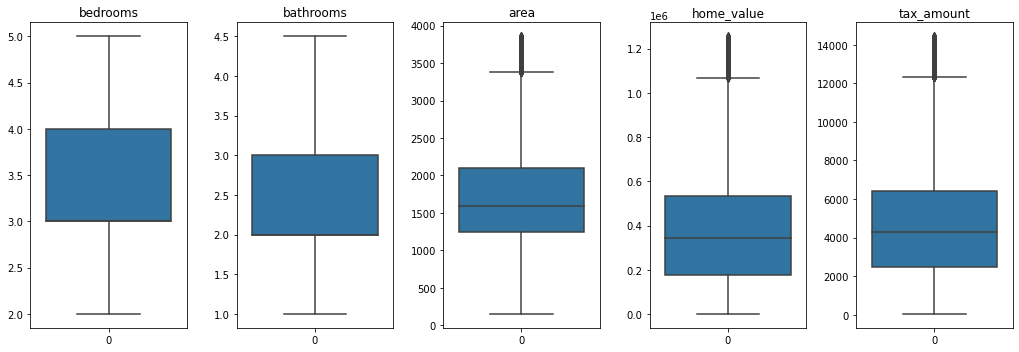

In [47]:
# add to function 
plt.figure(figsize=(20,5))
i=1

for col in df.drop(columns=['county', 'year_built']).columns:
   
    plt.subplot(1, len(df.columns), i)
    sns.boxplot(data=df[col])
    plt.title(col)
    i += 1
plt.tight_layout()
plt.show()

## Takeaways
* LA County highest amount of homes by far
* Bathrooms, Bedrooms, area, and year built pretty normal distribution
* tax_amount and home_value seem heavily correlated
* add code for visuals into prep function so they are automatically generated for explore phase